In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# 데이터 불러오기
data_origin = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projects/2024_contest_fog/Data/train_data.csv')

In [5]:
# 데이터 불러오기 / copy
data=data_origin.copy()

In [6]:
# 이상치 탐지 및 처리
def handle_outliers(data):
    # fog_train.ws10_deg: -99.9는 선형 보간법으로 처리
    data['fog_train.ws10_deg'].replace([-99.9,0], np.nan, inplace=True)
    # data['fog_train.ws10_deg'].replace(0, np.nan, inplace=True)
    # 0도 너무 많아서 보간법으로 처리
    data['fog_train.ws10_deg'] = data['fog_train.ws10_deg'].interpolate(method='linear')
    # data['fog_train.ws10_deg'] = data['fog_train.ws10_deg'].interpolate(method='linear')

    # fog_train.ws10_deg: -99.9는 선형 보간법으로 처리
    data['fog_train.ws10_ms'].replace(-99.9, np.nan, inplace=True)
    data['fog_train.ws10_ms'] = data['fog_train.ws10_ms'].interpolate(method='linear')

    # fog_train.ta: -99.9는 선형 보간법으로 처리
    data['fog_train.ta'].replace(-99.9, np.nan, inplace=True)
    data['fog_train.ta'] = data['fog_train.ta'].interpolate(method='linear')

    # fog_train.re: -99.9는 drop
    data = data[data['fog_train.re'] != -99.9]

    # fog_train.hm: -99.9는 선형 보간법으로 처리
    data['fog_train.hm'].replace(-99.9, np.nan, inplace=True)
    data['fog_train.hm'] = data['fog_train.hm'].interpolate(method='linear')

    # fog_train.sun10: -99.90는 선형 보간법으로 처리
    data['fog_train.sun10'].replace(-99.90, np.nan, inplace=True)
    data['fog_train.sun10'] = data['fog_train.sun10'].interpolate(method='linear')

    # fog_train.ts: -99.9를 선형 보간법으로 처리
    data['fog_train.ts'].replace(-99.9, np.nan, inplace=True)
    data['fog_train.ts'] = data['fog_train.ts'].interpolate(method='linear')

    # fog_train.vis1: -99는 선형 보간법으로 처리
    data['fog_train.vis1'].replace(-99, np.nan, inplace=True)
    data['fog_train.vis1'] = data['fog_train.vis1'].interpolate(method='linear')

    # fog_train.class: -99는 drop
    data = data[data['fog_train.class'] != -99]

    return data

# 이상치 처리
data = handle_outliers(data)

# 데이터 정보 출력
print("Dataset Information after handling outliers:")
data.info()

Dataset Information after handling outliers:
<class 'pandas.core.frame.DataFrame'>
Index: 3121179 entries, 0 to 3156458
Data columns (total 16 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Unnamed: 0          int64  
 1   fog_train.year      object 
 2   fog_train.month     int64  
 3   fog_train.day       int64  
 4   fog_train.time      int64  
 5   fog_train.minute    int64  
 6   fog_train.stn_id    object 
 7   fog_train.ws10_deg  float64
 8   fog_train.ws10_ms   float64
 9   fog_train.ta        float64
 10  fog_train.re        float64
 11  fog_train.hm        float64
 12  fog_train.sun10     float64
 13  fog_train.ts        float64
 14  fog_train.vis1      float64
 15  fog_train.class     int64  
dtypes: float64(8), int64(6), object(2)
memory usage: 404.8+ MB


In [7]:
# 각 특징별 unique 값 개수 확인
unique_counts = data.nunique()
print("\nUnique values per feature:")
print(unique_counts)

# 각 특징의 unique 값과 개수 출력
for column in data.columns:
    unique_values = data[column].value_counts()
    unique_count = unique_counts[column]
    print(f"\n{column}: {unique_count} unique values")
    # print(unique_values)  # 첫 10개의 고유 값과 개수만 출력 (많은 경우를 대비)


Unique values per feature:
Unnamed: 0            3121179
fog_train.year              3
fog_train.month            12
fog_train.day              31
fog_train.time             24
fog_train.minute            6
fog_train.stn_id           20
fog_train.ws10_deg      50380
fog_train.ws10_ms        1636
fog_train.ta             1068
fog_train.re                2
fog_train.hm             1242
fog_train.sun10         10193
fog_train.ts            27313
fog_train.vis1          51022
fog_train.class             4
dtype: int64

Unnamed: 0: 3121179 unique values

fog_train.year: 3 unique values

fog_train.month: 12 unique values

fog_train.day: 31 unique values

fog_train.time: 24 unique values

fog_train.minute: 6 unique values

fog_train.stn_id: 20 unique values

fog_train.ws10_deg: 50380 unique values

fog_train.ws10_ms: 1636 unique values

fog_train.ta: 1068 unique values

fog_train.re: 2 unique values

fog_train.hm: 1242 unique values

fog_train.sun10: 10193 unique values

fog_train.ts: 27313 

In [8]:
# # unique 값과 그 개수를 파일에 저장
# with open('unique_preprocessed_values_counts.txt', 'w') as file:
#     for column in data.columns:
#         unique_values = data[column].value_counts()
#         unique_count = unique_counts[column]
#         file.write(f"\n{column}: {unique_count} unique values\n")
#         file.write(unique_values.to_string())
#         file.write("\n\n")

In [9]:
import pandas as pd
import numpy as np

# target 값 분리
# target_vis1 = data['fog_train.vis1'] -> 보관할 필요가 없음
# target_class = data['fog_train.class']

# target 값 삭제한 나머지 데이터 보관
data = data.drop(columns=['Unnamed: 0','fog_train.vis1'])

In [10]:
# 'fog_train.re' 범주형 데이터로 변환
data['fog_train.re'] = data['fog_train.re'].map({0: 'rain X', 1: 'rain'})

# 'fog_train.class' 범주형 데이터로 변환 -> 할 필요없다는데
# class_mapping = {1: '안개1', 2: '안개2', 3: '안개3', 4: '안개4'}
# data['fog_train.class'] = data['fog_train.class'].map(class_mapping)

In [11]:
# 두 변수의 차이 새로운 변수 생성
data['fog_train.diff_tats'] = data['fog_train.ta'] - data['fog_train.ts']

# 원래 변수 삭제, 'fog_train.ts' -> 지면 온도 삭제
data = data.drop(columns=['fog_train.ts'])

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 숫자형 열과 범주형 열 추출
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = data.select_dtypes(include=['object', 'category']).columns

print("\nNumerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)

# 각 열의 분포 시각화
def plot_numerical(data, col):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.histplot(data[col], ax=axes[0], kde=True)
    axes[0].set_title(f'Histogram of {col}')
    sns.boxplot(x=data[col], ax=axes[1])
    axes[1].set_title(f'Boxplot of {col}')
    plt.show()

def plot_categorical(data, col):
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, data=data)
    plt.title(f'Countplot of {col}')
    plt.show()

# # 수치형 변수 시각화
# for col in numerical_cols:
#     plot_numerical(data, col)

# # 범주형 변수 시각화
# for col in categorical_cols:
#     plot_categorical(data, col)


Numerical Columns: Index(['fog_train.month', 'fog_train.day', 'fog_train.time',
       'fog_train.minute', 'fog_train.ws10_deg', 'fog_train.ws10_ms',
       'fog_train.ta', 'fog_train.hm', 'fog_train.sun10', 'fog_train.class',
       'fog_train.diff_tats'],
      dtype='object')
Categorical Columns: Index(['fog_train.year', 'fog_train.stn_id', 'fog_train.re'], dtype='object')


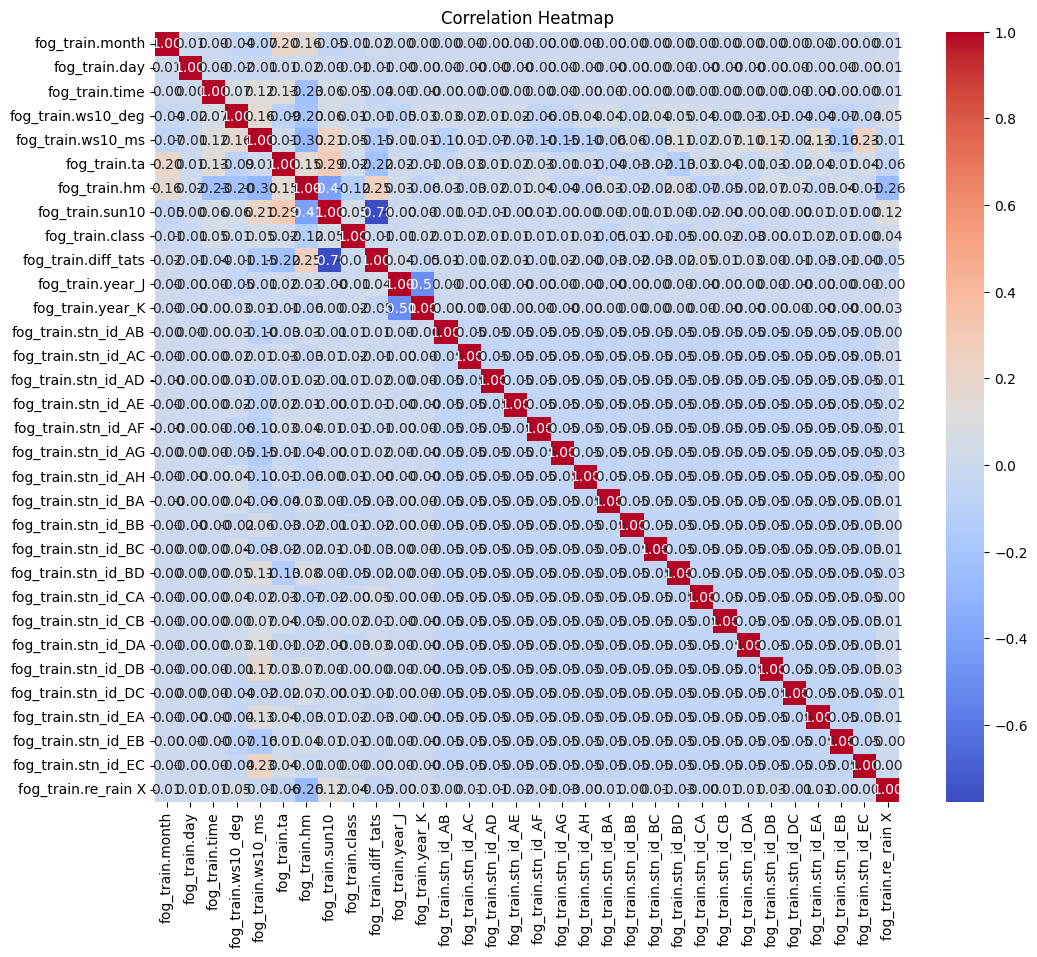

In [13]:
# 불필요한 열 삭제
data_notdate = data.drop(columns=['fog_train.minute']).copy()
data_numerical=data_notdate.drop(columns=categorical_cols)

# 범주형 열과 숫자형 열 분리
categorical_cols = data_notdate.select_dtypes(include=['object', 'category']).columns
numerical_cols = data_notdate.select_dtypes(include=['int64', 'float64']).columns

# 범주형 데이터 원-핫 인코딩
data = pd.get_dummies(data_notdate, columns=categorical_cols, drop_first=True)

# 상관관계 계산
correlation_matrix = data.corr()

# 히트맵 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [14]:
data.dropna(inplace=True)

In [15]:
# 3. 특징 선택 및 엔지니어링
# 특징 선택: 상관계수, 피처 중요도 등을 통해 중요한 특징을 선택합니다.
# 특징 엔지니어링: 날짜 및 시간 데이터를 통해 새로운 특징을 생성하거나, 파생 변수를 추가합니다.
from sklearn.feature_selection import SelectKBest, f_classif

# 특징 선택
X = data.drop(columns=['fog_train.class'])
y = data['fog_train.class']

selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X, y)
scores = selector.scores_

# 특징과 점수를 묶어 리스트로 만들고 점수를 기준으로 정렬
features_scores = sorted(zip(X.columns, scores), key=lambda x: x[1], reverse=True)

# 중요 특징 출력
for feature, score in features_scores:
    print(f"Feature: {feature}, Score: {score:.4f}")

Feature: fog_train.hm, Score: 17821.3708
Feature: fog_train.re_rain X, Score: 8819.0222
Feature: fog_train.stn_id_BA, Score: 3917.2938
Feature: fog_train.stn_id_BD, Score: 3153.3372
Feature: fog_train.sun10, Score: 2953.1101
Feature: fog_train.time, Score: 2786.2179
Feature: fog_train.ws10_ms, Score: 2385.3295
Feature: fog_train.stn_id_DA, Score: 1245.6707
Feature: fog_train.ta, Score: 658.3701
Feature: fog_train.stn_id_CB, Score: 514.2186
Feature: fog_train.stn_id_AC, Score: 452.3109
Feature: fog_train.year_K, Score: 311.4544
Feature: fog_train.month, Score: 279.7703
Feature: fog_train.stn_id_EA, Score: 271.2822
Feature: fog_train.stn_id_AH, Score: 196.4807
Feature: fog_train.stn_id_AF, Score: 193.9056
Feature: fog_train.diff_tats, Score: 191.0570
Feature: fog_train.stn_id_AD, Score: 148.0397
Feature: fog_train.ws10_deg, Score: 134.1737
Feature: fog_train.stn_id_BC, Score: 113.5113
Feature: fog_train.day, Score: 112.9613
Feature: fog_train.stn_id_EC, Score: 99.7972
Feature: fog_train.

# 순서
위는 전처리에 관련된 것
아래는 모델의 평가에 관한 것들이다.

In [ ]:
!pip install flaml

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from flaml import AutoML
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 불러오기 및 전처리 (생략)

# X, y 분리
X = data.drop(columns=['fog_train.class'])
y = data['fog_train.class'] - 1

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# AutoML 모델 정의 및 학습 (일부 데이터로 확인)
automl = AutoML()

# 일부 데이터만 사용하여 학습 확인 (예: 10%)
sample_size = int(0.1 * len(X_train))
X_train_sample = X_train[:sample_size]
y_train_sample = y_train[:sample_size]

automl.fit(X_train_sample, y_train_sample, task='classification', time_budget=60, log_file_name="automl.log")

# 진행상황 출력
print("Best ML learner:", automl.best_estimator)
print("Best hyperparameter config:", automl.best_config)
print("Best accuracy on validation data: {0:.4g}".format(automl.best_loss))

# 전체 데이터로 학습
automl.fit(X_train, y_train, task='classification', time_budget=600, log_file_name="automl.log")

# 최종 모델 예측
y_pred = automl.predict(X_test)

# 성능 평가
print(classification_report(y_test, y_pred))

# 혼동 행렬 시각화
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()